<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [1]:
#!pip install tensorboard evaluate transformers datasets pymorphy2 -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Импортируем необходимые библиотеки для дальнейшего анализа

import os
import gc
import random
import copy
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import nltk
import pymorphy2
nltk.download('stopwords')
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import evaluate

import transformers
from transformers import BertTokenizer, BertModel, get_scheduler

sns.set(palette='summer')

print('Все библиотеки импортированы')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Все библиотеки импортированы


In [4]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

Fri Apr 26 16:10:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             11W /  170W |   10068MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

'cuda'

In [5]:
SEED = 42

def seed_torch(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch(SEED)

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#%cd /content/drive/MyDrive/DLS/DLS_2s_2024/11. Домашнее задание. Предобучение и файнтьюн языковых моделей/data
#!ls

In [8]:
# Загрузим данные, посмотрим на их структуру

data = pd.read_excel('./data_problems_translated.xlsx', index_col=0)
print(data.shape)
data.head()

(5273, 2)


,problem_text,topic
0,To prove that the sum of the numbers of the ex...,number_theory
1,( b) Will the statement of the previous challe...,number_theory
2,The quadratic three-member graph with the coef...,polynoms
3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,"Dima, who came from Vrunlandia, said that ther...",graphs


In [9]:
data.columns = ['text','label']

In [10]:
print(f'Количество уникальных лейблов: {data.label.nunique()}')
data.label.value_counts()

Количество уникальных лейблов: 7


label
number_theory    2396
combinatorics    1020
dirichlet         441
polynoms          426
graphs            384
geometry          371
invariant         235
Name: count, dtype: int64

,len_text
count,5273.000000
mean,229.931538
std,215.601297
min,0.000000
25%,105.000000
50%,179.000000
75%,286.000000
max,2506.000000


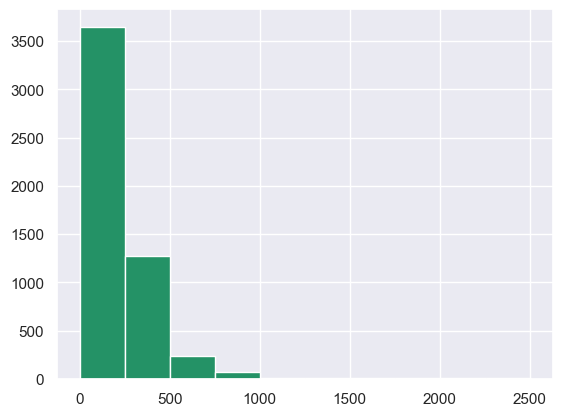

In [11]:
data['text'] = data['text'].fillna('').astype(str)
data['len_text'] = data.text.apply(lambda x: len(str(x)))
display(data.describe())
data.len_text.hist()
None

In [12]:
# Проверка на дубликаты в данных

data.shape, data.drop_duplicates().shape, data.drop_duplicates('text').shape

((5273, 3), (5244, 3), (4319, 3))

In [13]:
data.groupby('text').label.nunique().sort_values(ascending=False).reset_index().head()

,text,label
0,"It's okay. It's okay, it's okay, it's okay.",7
1,"On the big chess board, 2n cells were marked s...",4
2,Each of the 102 pupils in one school is famili...,4
3,( a) Could it happen that in a company of 10 g...,4
4,How can n > 1 happen in a company of n + 1 gir...,4


In [14]:
data.dtypes, data.isna().sum()

(text        object
 label       object
 len_text     int64
 dtype: object,
 text        0
 label       0
 len_text    0
 dtype: int64)

In [15]:
data[data.text.str.contains("It's okay. It's okay")].drop_duplicates(['text','label'])

,text,label,len_text
548,"It's okay. It's okay, it's okay, it's okay.",graphs,43
968,"It's okay. It's okay, it's okay, it's okay.",dirichlet,43
1665,"It's okay. It's okay, it's okay, it's okay.",geometry,43
1995,"It's okay. It's okay, it's okay, it's okay.",combinatorics,43
2211,"It's okay. It's okay, it's okay, it's okay.",number_theory,43
2281,"It's okay. It's okay, it's okay, it's okay.",polynoms,43
3668,"It's okay. It's okay, it's okay, it's okay.",invariant,43


---
## Вывод:
* В данных есть дубликаты по задачам, однако каждый из них имеет несколько Тем! Таким образом решение задачи может быть либо задача Multilabel, либо при вычистке дубликатов можно решать задачу Multiclass.
* Длина предложения самого текста задачи от 0 до 2506 симовлов, при 50 и 75 квантиле 179 и 286 соответственно. Таким образом падить будет не очень хорошей идеей, надо фильтрануть наблюдения по длине предложения

---
1) Удалим Дубликаты по конверсии лейблов

In [16]:
# Заведем ранжировку для каждого из лейблов и возьмем тот, где первого, где меньше количество наблюдений

rang_dict = {k:v for v,k in enumerate(data.label.value_counts().sort_values().index)}
data['rang_label'] = data.label.map(rang_dict)

In [17]:
(data.sort_values(['text','rang_label']).drop_duplicates('text',keep='first').drop(columns='rang_label').label.value_counts()
,data.sort_values(['text','rang_label']).drop_duplicates('text',keep='last').drop(columns='rang_label').label.value_counts())

(label
 number_theory    1964
 combinatorics     577
 polynoms          407
 dirichlet         390
 graphs            379
 geometry          367
 invariant         235
 Name: count, dtype: int64,
 label
 number_theory    2391
 combinatorics     811
 geometry          363
 polynoms          357
 dirichlet         268
 invariant         117
 graphs             12
 Name: count, dtype: int64)

In [18]:
# Заведем ранжировку для каждого из лейблов и возьмем тот, где первого, где меньше количество наблюдений

rang_dict = {k:v for v,k in enumerate(data.label.value_counts().sort_values().index)}
data['rang_label'] = data.label.map(rang_dict)
data = data.sort_values(['text','rang_label']).drop_duplicates('text',keep='first').drop(columns='rang_label')

In [19]:
from sklearn.model_selection import train_test_split

label_to_ind = {label:ind for ind,label in enumerate(data.label.unique())}
int_to_label = {ind: label for label, ind in label_to_ind.items()}
NUM_CLASSES = len(label_to_ind)

data['label'] = data['label'].map(label_to_ind)

train_data, eval_data = train_test_split(data[['text','label']], stratify=data['label'], test_size=0.15, random_state=SEED, shuffle=True)

---
2) Посмотрим на выбросы по длинам предложений

In [20]:
# Part of code is from Seminar Attention and Transformers

ENG_STOP_WORDS = set(stopwords.words('english'))
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer() # for preprocess
# for broadening your horizons use it for lemmatization
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    punct_filtered_text = ''.join(
        [ch for ch in nums_filtered_text if ch not in string.punctuation]
    )
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    filtr_stop_words_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                             if token not in ENG_STOP_WORDS]
    norm_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in filtr_stop_words_tokens]

    return f"[CLS] {' '.join(norm_tokens)}"

In [21]:
# Слелаем расчет на Интерквартильный размах и посчитаем выбросы по длине предложений

from scipy.stats import iqr

data = data[data.len_text>=data.len_text.quantile(0.01)]

print(data.len_text.quantile(0.25)-iqr(data.len_text),
      data.len_text.quantile(0.25),
      data.len_text.quantile(0.5),
      data.len_text.quantile(0.75),
      data.len_text.quantile(0.75)+iqr(data.len_text))

-77.0 104.0 176.0 285.0 466.0


In [22]:
# Part of code is from Seminar Attention and Transformers
## Changed hug_dataset to my_dataset

MAX_LENGTH = int(data.len_text.quantile(0.75))

class MyDataset(Dataset):
  def __init__(self,
               my_dataset,
               tokenizer,
               device=DEVICE):

    self.text = my_dataset['text'].apply(lambda x: preprocess_text(x)).tolist()
    self.target = my_dataset['label'].tolist()
    self.tokenizer = tokenizer
    self.device = device

  def __getitem__(self, idx):
    prep_text = self.text[idx]
    target = self.target[idx]

    tokenized_text = self.tokenizer(text=prep_text,
                                    padding="max_length",
                                    max_length=MAX_LENGTH,
                                    truncation=True,
                                    return_tensors='pt')

    text_ids = tokenized_text['input_ids'].flatten()
    attention_mask = tokenized_text['attention_mask'].flatten()

    return text_ids, attention_mask, torch.tensor(target, dtype=torch.long)

  def __len__(self):
    return len(self.text)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [23]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model, num_classes: int=NUM_CLASSES):
        super().__init__()
        self.backbone = base_transformer_model
        # YOUR CODE: create additional layers for classfication
        hidden_size = self.backbone.config.hidden_size
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(in_features=hidden_size, out_features=num_classes)


    def forward(self, input_ids, attention_mask):
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooler_outputs = self.dropout(outputs.pooler_output)
        pooler_outputs = self.tanh(pooler_outputs)
        logits = self.linear(pooler_outputs)

        return logits, outputs.attentions

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [24]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [25]:
acc_metric = evaluate.load("accuracy")
#precision_metric = evaluate.load("precision")
#recall_metric = evaluate.load("recall")
#f1_metric = evaluate.load("f1")


def train_transformer(transformer_model, n_epochs, train_dataloader, eval_dataloader, freeze_backbone=True, device=DEVICE):
    model = copy.deepcopy(transformer_model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    history_loss = {'train':[], 'valid':[]}
    history_acc = {'train':[], 'valid':[]}
    tr_history_metrics = {'recall':[],'precision':[],'f1':[]}
    val_history_metrics = {'recall':[],'precision':[],'f1':[]}

    if freeze_backbone:
        model = freeze_backbone_function(model)

    for epoch_number in tqdm(range(n_epochs)):
        model.train()
        tr_loss = 0
        cnt_answers = 0
        cnt_right_answers = 0

        for data in train_dataloader:
            optimizer.zero_grad()

            input_data, attention_mask, labels = data
            input_data, attention_mask, labels = input_data.to(device), attention_mask.to(device), labels.to(device).long()

            outputs,_ = model(input_data, attention_mask)

            pred = outputs.argmax(axis=-1)
            loss = criterion(outputs, labels)

            tr_loss += loss.item()
            cnt_answers += labels.shape[0]
            cnt_right_answers += (pred == labels).sum().item()

            loss.backward()
            optimizer.step()

        history_loss['train'].append(tr_loss / len(train_dataloader))
        history_acc['train'].append(cnt_right_answers / cnt_answers)
#        tr_history_metrics['precision'].append(precision_metric.compute(predictions=pred, references=labels, average="macro"))
#        tr_history_metrics['recall'].append(recall_metric.compute(predictions=pred, references=labels, average="macro"))
#        tr_history_metrics['f1'].append(f1_metric.compute(predictions=pred, references=labels, average="macro"))

        model.eval()
        val_loss = 0
        vcnt_answers = 0
        vcnt_right_answers = 0

        with torch.no_grad():
            for vdata in tqdm(eval_dataloader):
                input_data, attention_mask, labels = vdata
                input_data, attention_mask, labels = input_data.to(device), attention_mask.to(device), labels.to(device).long()

                outputs,_ = model(input_data, attention_mask)
                pred = outputs.argmax(axis=-1)
                vloss = criterion(outputs, labels)

                val_loss += vloss.item()
                vcnt_answers += labels.shape[0]
                vcnt_right_answers += (pred == labels).sum().item()

            history_loss['valid'].append(val_loss / len(eval_dataloader))
            history_acc['valid'].append(vcnt_right_answers / vcnt_answers)
    #        val_history_metrics['precision'].append(precision_metric.compute(predictions=pred, references=labels, average="macro"))
    #        val_history_metrics['recall'].append(recall_metric.compute(predictions=pred, references=labels, average="macro"))
    #        val_history_metrics['f1'].append(f1_metric.compute(predictions=pred, references=labels, average="macro"))

            print('EPOCH {}:'.format(epoch_number + 1), "\n**TRAIN** loss:", tr_loss / len(train_dataloader),
                  "**TRAIN** Accuracy:", cnt_right_answers / cnt_answers,
                  "\n**EVAL** loss:", val_loss / len(eval_dataloader),
                  "**EVAL** Accuracy:", vcnt_right_answers / vcnt_answers,
                  '\n','-'*150
                 )
            del input_data, attention_mask, labels

        torch.cuda.empty_cache()
        gc.collect()

    return model, history_loss, history_acc

In [26]:
# Отрисовка графиков обучения

def history_plot(history_loss, history_acc, name):
    fig, ax = plt.subplots(1,2, figsize=(16, 6))

    ax[0].plot(history_loss['train'], label="train_loss",color='lightblue')
    ax[0].plot(history_loss['valid'], label="val_loss",color='orange')
    ax[0].legend(['train', 'valid'])
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel("loss")
    plt.grid()

    ax[1].plot(history_acc['train'], label="train_acc",color='lightblue')
    ax[1].plot(history_acc['valid'], label="val_acc",color='orange')
    ax[1].legend(['train', 'valid'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel("accuracy")
    plt.grid()

    fig.suptitle(f'History of "{name}" model')
    plt.show()

# Складовщик метрики по валидации, для определения лучшей модели
MEAN_ACC_MODELS_HISTORY = {}

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [27]:
MODEL_NAME = 'cointegrated/rubert-tiny2'
MODEL_NAME_frz = MODEL_NAME +'_frz'
tokenizer_rt = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = MyDataset(train_data, tokenizer_rt)
eval_dataset = MyDataset(eval_data, tokenizer_rt)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [28]:
EPOCHS = 7
pretrained_model_rt = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
model_rt = TransformerClassificationModel(pretrained_model_rt).to(DEVICE)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN** loss: 1.9133000441219497 **TRAIN** Accuracy: 0.26804685371833287 
**EVAL** loss: 1.9031337293577784 **EVAL** Accuracy: 0.3333333333333333 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN** loss: 1.8940081197282543 **TRAIN** Accuracy: 0.3470444020702806 
**EVAL** loss: 1.8841091674051167 **EVAL** Accuracy: 0.4058641975308642 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN** loss: 1.8745912945788838 **TRAIN** Accuracy: 0.410787251430128 
**EVAL** loss: 1.866071383158366 **EVAL** Accuracy: 0.4444444444444444 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN** loss: 1.8580800942752673 **TRAIN** Accuracy: 0.43394170525742304 
**EVAL** loss: 1.8487985369599895 **EVAL** Accuracy: 0.46141975308641975 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN** loss: 1.8410535921221194 **TRAIN** Accuracy: 0.4497412149278126 
**EVAL** loss: 1.8320744802922377 **EVAL** Accuracy: 0.4691358024691358 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN** loss: 1.8244725263637045 **TRAIN** Accuracy: 0.46227186052846636 
**EVAL** loss: 1.8160172494841211 **EVAL** Accuracy: 0.4660493827160494 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN** loss: 1.807914111925208 **TRAIN** Accuracy: 0.46090983383274314 
**EVAL** loss: 1.800654038970853 **EVAL** Accuracy: 0.4675925925925926 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


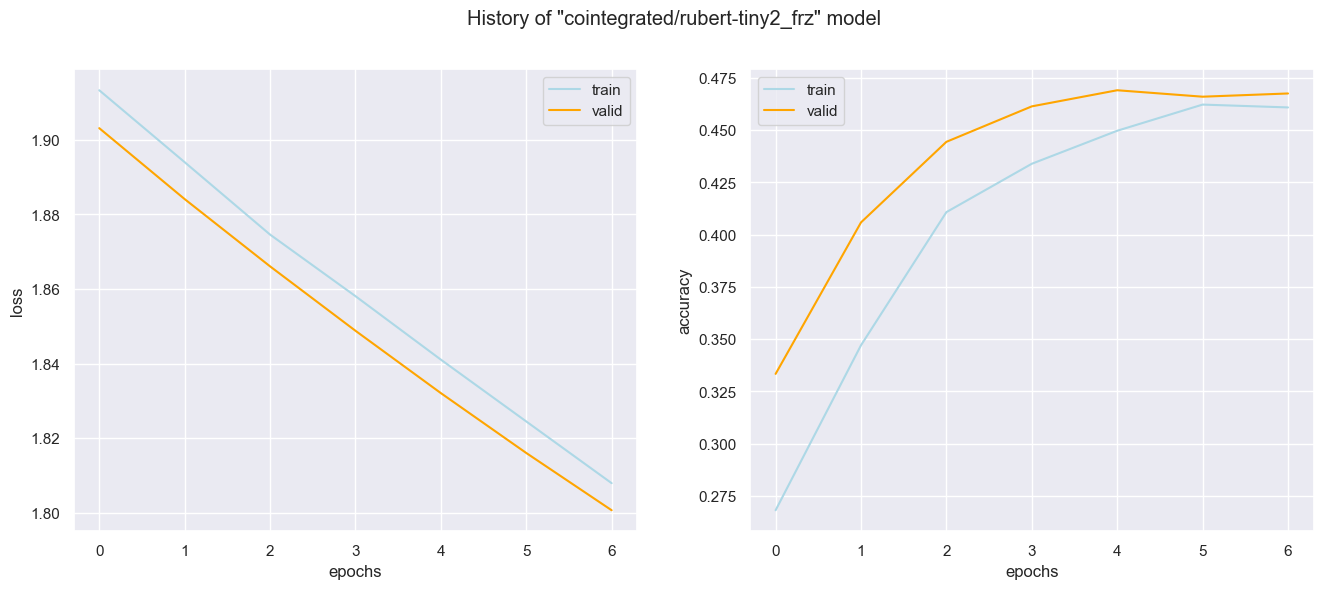

In [29]:
rubert_tiny_frz, rt_history_loss_frz, rt_history_acc_frz = train_transformer(transformer_model=model_rt
                                                                             ,n_epochs=EPOCHS
                                                                             ,train_dataloader=train_loader
                                                                             ,eval_dataloader=eval_loader
                                                                             ,freeze_backbone=True
                                                                             ,device=DEVICE)

history_plot(rt_history_loss_frz, rt_history_acc_frz, MODEL_NAME_frz)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME_frz] = np.mean(rt_history_acc_frz['valid'])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN** loss: 1.631309553851252 **TRAIN** Accuracy: 0.45301007899754836 
**EVAL** loss: 1.4327669474813673 **EVAL** Accuracy: 0.5046296296296297 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN** loss: 1.3436011954494145 **TRAIN** Accuracy: 0.5538000544810678 
**EVAL** loss: 1.2081753920625757 **EVAL** Accuracy: 0.5864197530864198 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN** loss: 1.181205466778382 **TRAIN** Accuracy: 0.616998093162626 
**EVAL** loss: 1.1003998948468103 **EVAL** Accuracy: 0.6219135802469136 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN** loss: 1.0784630106843036 **TRAIN** Accuracy: 0.648597112503405 
**EVAL** loss: 1.0279771681920982 **EVAL** Accuracy: 0.6450617283950617 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN** loss: 1.0005023782667906 **TRAIN** Accuracy: 0.6709343503132661 
**EVAL** loss: 0.9830166616557557 **EVAL** Accuracy: 0.6759259259259259 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN** loss: 0.9379338200973428 **TRAIN** Accuracy: 0.6905475347316807 
**EVAL** loss: 0.9462536459351764 **EVAL** Accuracy: 0.6805555555555556 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN** loss: 0.8797823229561681 **TRAIN** Accuracy: 0.7098883138109507 
**EVAL** loss: 0.921833825700077 **EVAL** Accuracy: 0.6774691358024691 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


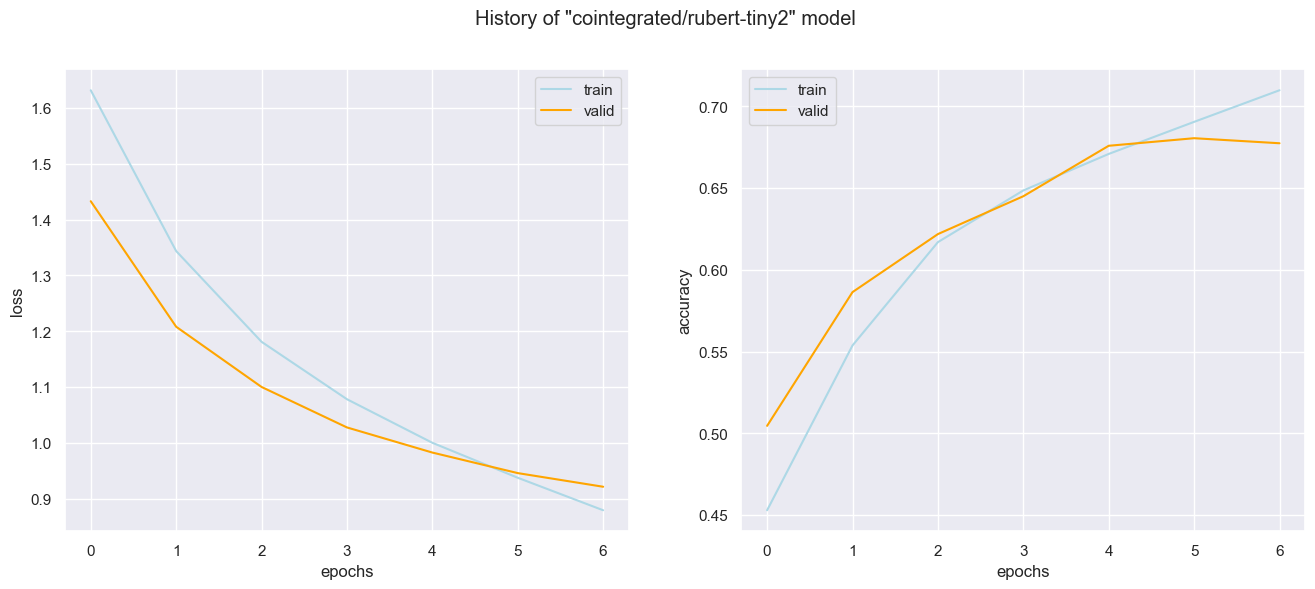

In [30]:
rubert_tiny_unfrz, rt_history_loss_unfrz, rt_history_acc_unfrz = train_transformer(transformer_model=model_rt
                                                                                   ,n_epochs=EPOCHS
                                                                                   ,train_dataloader=train_loader
                                                                                   ,eval_dataloader=eval_loader
                                                                                   ,freeze_backbone=False
                                                                                   ,device=DEVICE)
history_plot(rt_history_loss_unfrz, rt_history_acc_unfrz, MODEL_NAME)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME] = np.mean(rt_history_acc_unfrz['valid'])

In [31]:
MEAN_ACC_MODELS_HISTORY

{'accuracycointegrated/rubert-tiny2_frz': 0.43540564373897706,
 'accuracycointegrated/rubert-tiny2': 0.6274250440917107}

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [32]:
class MBClassificationModel(nn.Module):
    def __init__(self, base_transformer_model, num_classes: int=NUM_CLASSES):
        super().__init__()
        self.backbone = base_transformer_model
        self.linear = nn.Linear(in_features=self.backbone.config.hidden_size, out_features=num_classes)


    def forward(self, input_ids, attention_mask):
        # YOUR CODE: propagate inputs through the model. Return dict with logits
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.linear(outputs.pooler_output)

        return logits, outputs.attentions

In [33]:
MODEL_NAME = 'tbs17/MathBert'
MODEL_NAME_frz = MODEL_NAME +'_frz'
tokenizer_mb = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = MyDataset(train_data, tokenizer_mb)
eval_dataset = MyDataset(eval_data, tokenizer_mb)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=True)

In [34]:
pretrained_model_mb = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
model_mb = MBClassificationModel(pretrained_model_mb).to(DEVICE)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN** loss: 1.8275193318076757 **TRAIN** Accuracy: 0.34649959139199127 
**EVAL** loss: 1.7250816086192189 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN** loss: 1.691902680500694 **TRAIN** Accuracy: 0.4543721056932716 
**EVAL** loss: 1.6546808451782038 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN** loss: 1.6530012488365173 **TRAIN** Accuracy: 0.4546445110324162 
**EVAL** loss: 1.6340212792526057 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN** loss: 1.638213999375053 **TRAIN** Accuracy: 0.4546445110324162 
**EVAL** loss: 1.620195166564282 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN** loss: 1.6269231651140297 **TRAIN** Accuracy: 0.4546445110324162 
**EVAL** loss: 1.607779457245344 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN** loss: 1.611661814606708 **TRAIN** Accuracy: 0.4546445110324162 
**EVAL** loss: 1.595893050417488 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN** loss: 1.605486598222152 **TRAIN** Accuracy: 0.4546445110324162 
**EVAL** loss: 1.5840092102686565 **EVAL** Accuracy: 0.45524691358024694 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


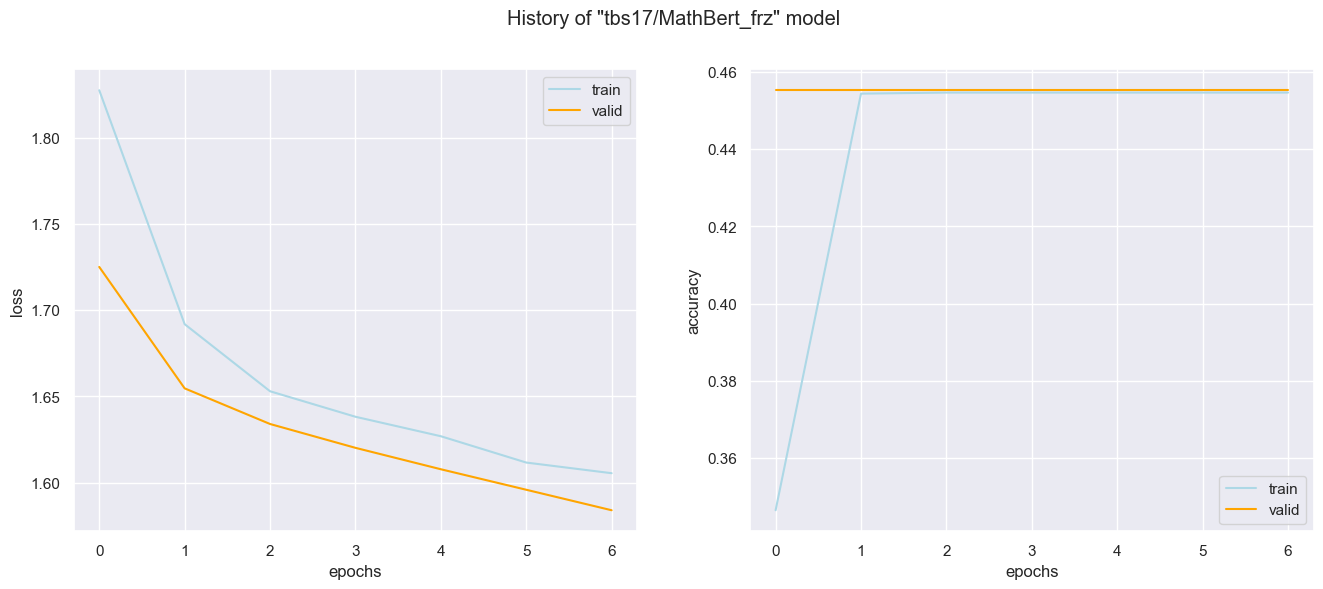

In [35]:
mathbert_frz, mb_history_loss_frz, mb_history_acc_frz = train_transformer(transformer_model=model_mb
                                                                          ,n_epochs=EPOCHS
                                                                          ,train_dataloader=train_loader
                                                                          ,eval_dataloader=eval_loader
                                                                          ,freeze_backbone=True
                                                                          ,device=DEVICE)

history_plot(mb_history_loss_frz, mb_history_acc_frz, MODEL_NAME_frz)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME_frz] = np.mean(mb_history_acc_frz['valid'])

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN** loss: 1.2090761052525563 **TRAIN** Accuracy: 0.5766821029692182 
**EVAL** loss: 1.0077821579244401 **EVAL** Accuracy: 0.6296296296296297 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN** loss: 0.8471148207135822 **TRAIN** Accuracy: 0.6957232361754291 
**EVAL** loss: 0.9140869106775449 **EVAL** Accuracy: 0.6851851851851852 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN** loss: 0.6365697529004968 **TRAIN** Accuracy: 0.7820757286842822 
**EVAL** loss: 0.9131669141812089 **EVAL** Accuracy: 0.6743827160493827 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN** loss: 0.418105207124482 **TRAIN** Accuracy: 0.8687006265322801 
**EVAL** loss: 0.9688206744598754 **EVAL** Accuracy: 0.6882716049382716 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN** loss: 0.23935938479135865 **TRAIN** Accuracy: 0.9329882865704168 
**EVAL** loss: 1.0931872380552468 **EVAL** Accuracy: 0.7052469135802469 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN** loss: 0.13205394177981045 **TRAIN** Accuracy: 0.9670389539634977 
**EVAL** loss: 1.2451501210438616 **EVAL** Accuracy: 0.6990740740740741 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/81 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN** loss: 0.09060296352304842 **TRAIN** Accuracy: 0.9771179515118497 
**EVAL** loss: 1.3210331414492777 **EVAL** Accuracy: 0.6959876543209876 
 ------------------------------------------------------------------------------------------------------------------------------------------------------


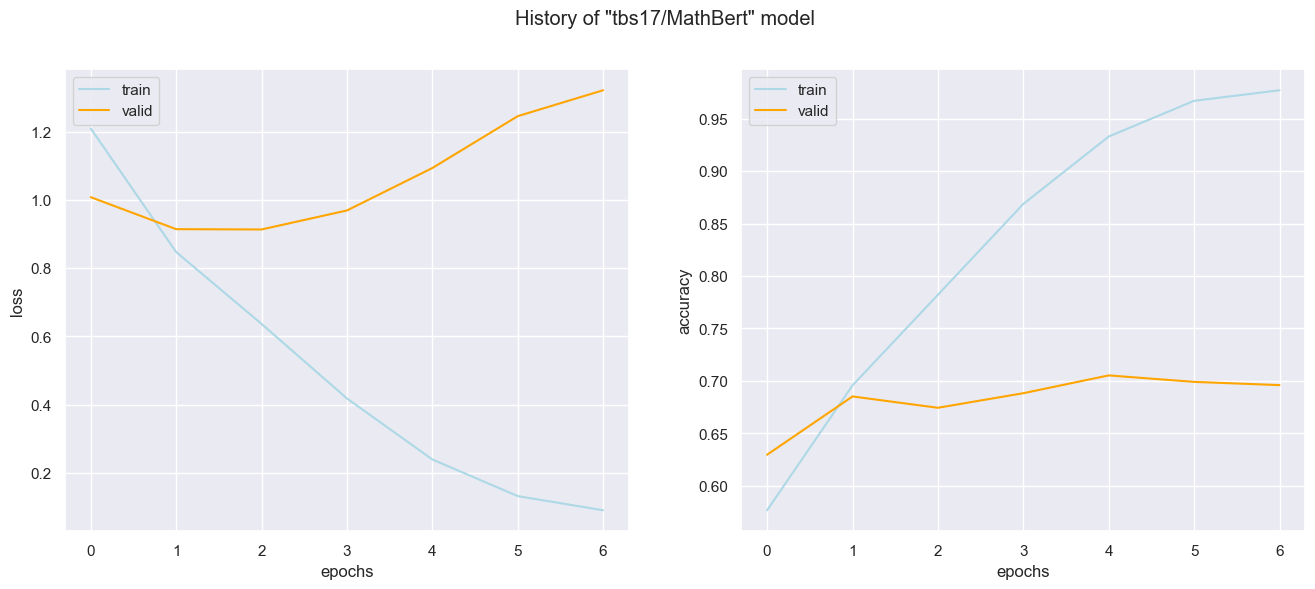

In [36]:
mathbert_unfrz, mathbert_history_loss_unfrz, mathbert_history_acc_unfrz = train_transformer(transformer_model=model_mb
                                                                                            ,n_epochs=EPOCHS
                                                                                            ,train_dataloader=train_loader
                                                                                            ,eval_dataloader=eval_loader
                                                                                            ,freeze_backbone=False
                                                                                            ,device=DEVICE)

history_plot(mathbert_history_loss_unfrz, mathbert_history_acc_unfrz, MODEL_NAME)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME] = np.mean(mathbert_history_acc_unfrz['valid'])

In [37]:
MEAN_ACC_MODELS_HISTORY

{'accuracycointegrated/rubert-tiny2_frz': 0.43540564373897706,
 'accuracycointegrated/rubert-tiny2': 0.6274250440917107,
 'accuracytbs17/MathBert_frz': 0.4552469135802469,
 'accuracytbs17/MathBert': 0.6825396825396826}

---
## Выводы по обучению 4х моделей

1) В TransformerClassificationModel при решении ДЗ добавлял dropout после скрытого слоя импотированной модели, и баловался с добавлением последовательной RNN с добавлением одного промежуточного слоя после скрытого состояния импортированной модели и линейным слоем на классификацию по темам с tanh функцией активации. Эксперимент проявил проявил себя +- норм в борьбе с переобучением, однако результаты не показали себя лучшим образом.
2) Перед обучением профильтровался на:
3)
    * Удаление дубликатов по задачам с разными лейблами (оставил те, которые реже встречаются, для нормализации баланса классов) - кстати идея возможно не из лучших, ибо до ее реализации модели показывали качество чуть лучше, но есть вероятность, что просто переобучались...
    * Фильтр на длину текста задачи. Отсеял все предложения, которые были по длине ниже 1% квантиля. По верхушке обрезал с помощью  3го квантиля (75%). Делалось для того, чтобы короткие предложения задач не заппадивались...
4) По самим моделям, видно, что все они обучаются, лосс падает, точность прогноза растет.
    * Однако модели с размороженными слоями предобученной архитектуры склоны к переобучению. Rubet-tiny начиная с 5ой, Mathbert после 2ой эпохи и улетает в небеса по трейну точности, в то время как на валидации точность остается +- постоянной, а лосс возрастает.
---

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [40]:
def draw_first_layer_attention_maps(text_loader,
                                    model,
                                    tokenizer,
                                    part_of_heads=0.5,
                                    device=DEVICE
                                   ):
    model.eval()
    model.backbone.config.output_attentions = True
    with torch.no_grad():
        text = next(iter(text_loader.text))

        inputs = tokenizer(text, return_tensors='pt')
        input_data = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        _, attentions = model(input_ids=input_data, attention_mask=attention_mask)

        first_layer_attentions = attentions[0]
        tokens = tokenizer.convert_ids_to_tokens(input_data[0])
        num_heads = first_layer_attentions.size(1)

        print(f"Всего голов Attention = {num_heads}, мы отрисуем {part_of_heads*100}% из них")
        num_heads = int(num_heads*part_of_heads)
        for head_id in range(num_heads):

            attention = first_layer_attentions[0, head_id].cpu().detach().numpy()

    #        plt.figure(figsize=(12, 12))
            sns.heatmap(attention, annot=False, cmap='viridis',xticklabels=tokens, yticklabels=tokens)
            plt.title(f"Head number {head_id} - attention map")
            plt.xlabel("tokens x")
            plt.ylabel("tokens y")
            plt.show()

        model.backbone.config.output_attentions = False

In [45]:
next(iter(train_dataset.text))

'[CLS] top cube eight different natural numbers recorded rib largest common divider two numbers recorded ends rib could sum numbers recorded vertebrates equal sum numbers recorded ribs'

Всего голов Attention = 12, мы отрисуем 50.0% из них


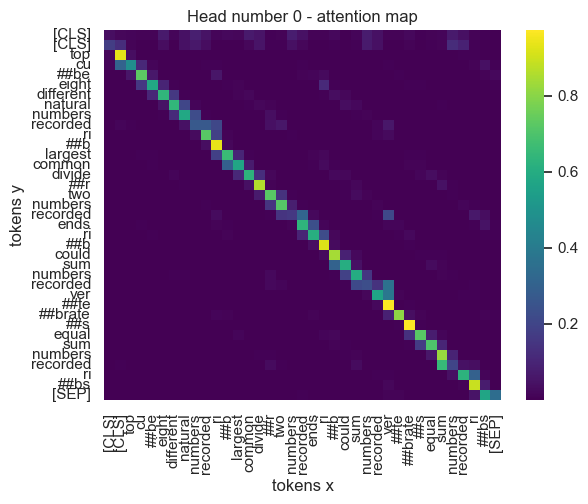

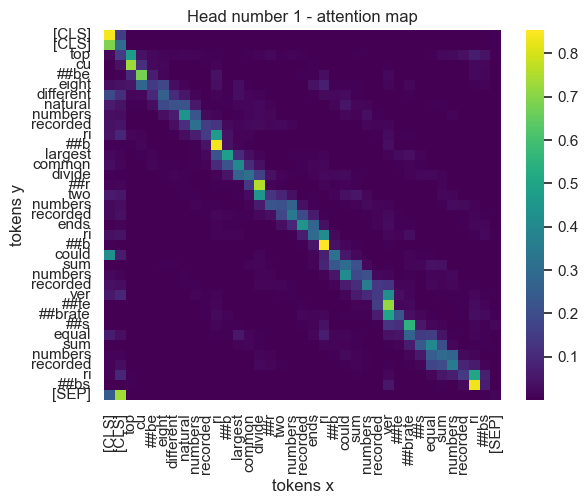

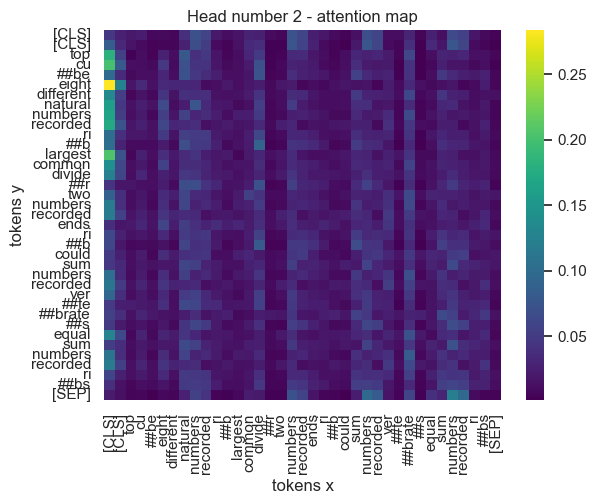

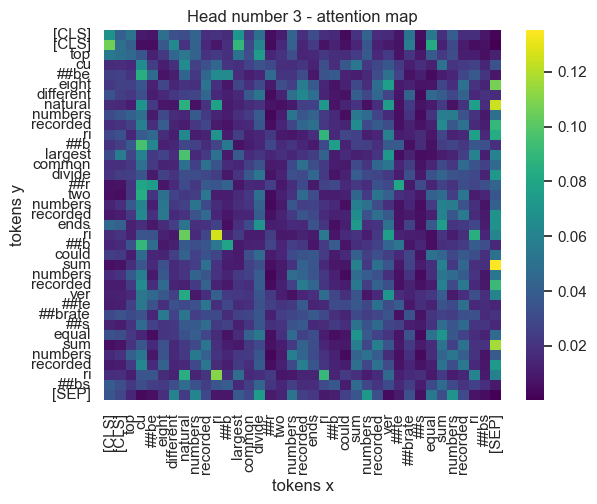

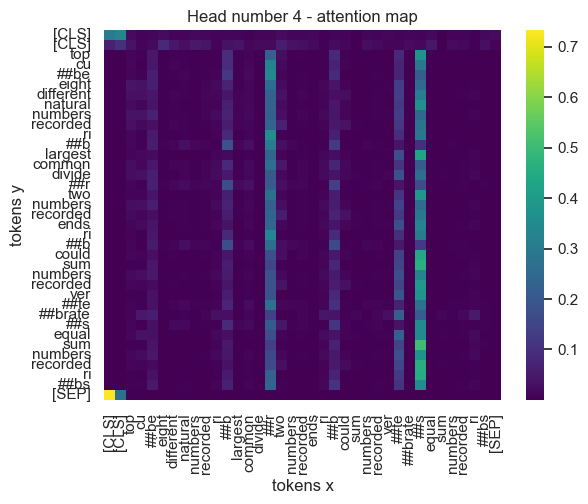

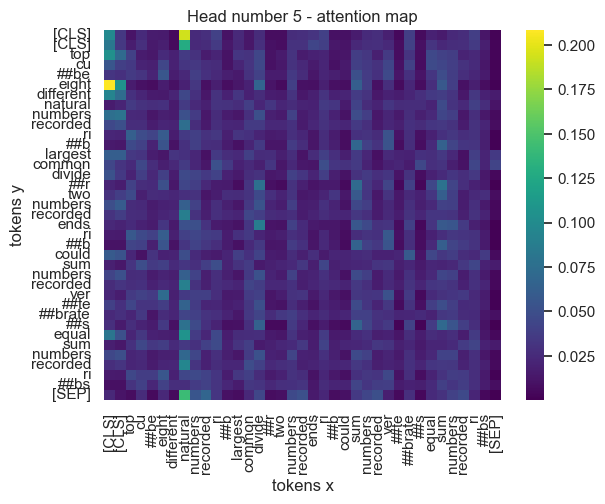

In [41]:
# Карта внимания для недообученной модели "Rubert - Tiny2"

brt = BertModel.from_pretrained("cointegrated/rubert-tiny2")
rubert_tiny_model = TransformerClassificationModel(brt, 7).to(DEVICE)
draw_first_layer_attention_maps(text_loader=train_dataset, model=rubert_tiny_model, tokenizer=tokenizer_rt)

Всего голов Attention = 12, мы отрисуем 50.0% из них


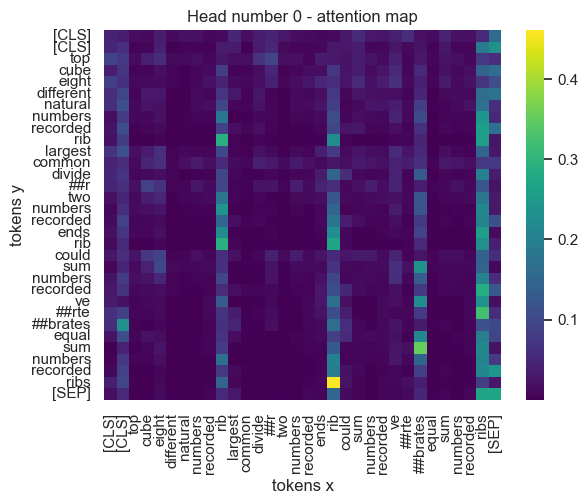

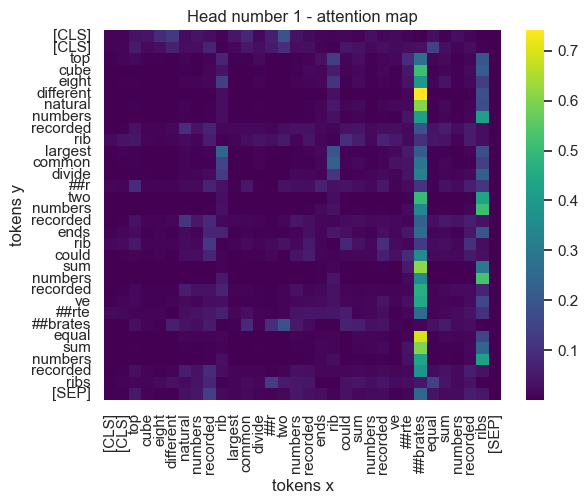

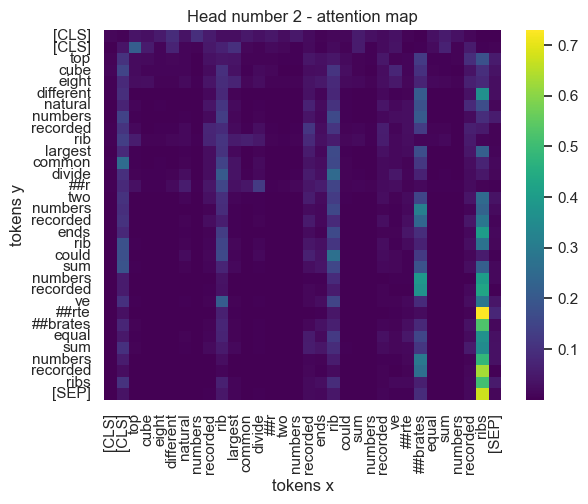

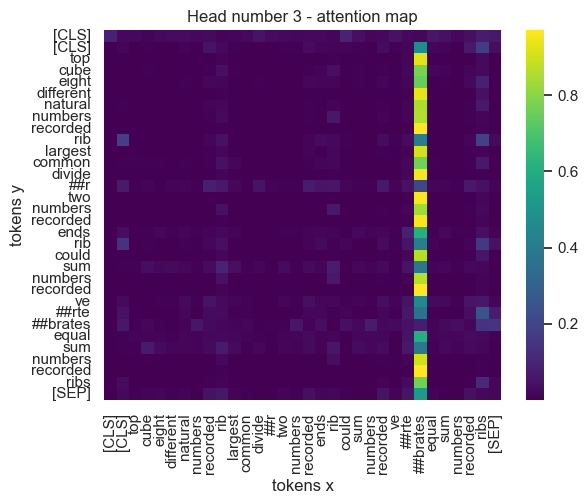

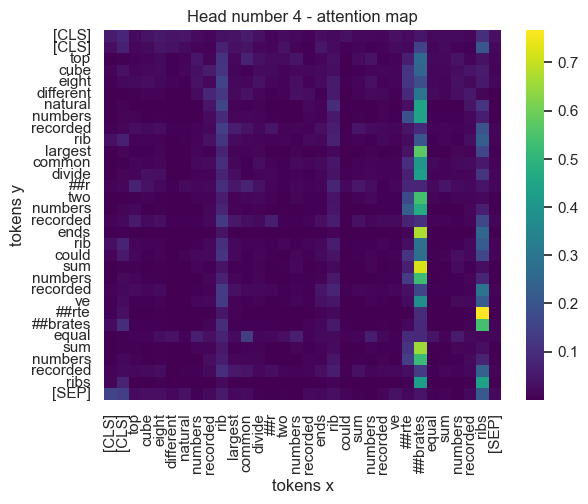

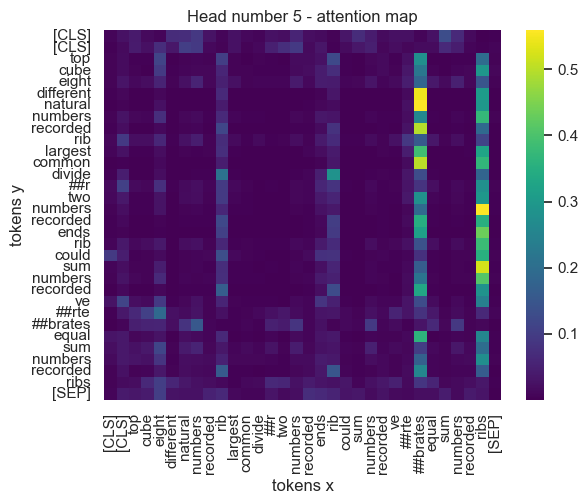

In [42]:
# Карта внимания для недообученной модели "MathBert"

mth = BertModel.from_pretrained('tbs17/MathBert')
mathbert_model = TransformerClassificationModel(mth, 7).to(DEVICE)
draw_first_layer_attention_maps(text_loader=train_dataset, model=mathbert_model, tokenizer=tokenizer_mb)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Всего голов Attention = 12, мы отрисуем 50.0% из них


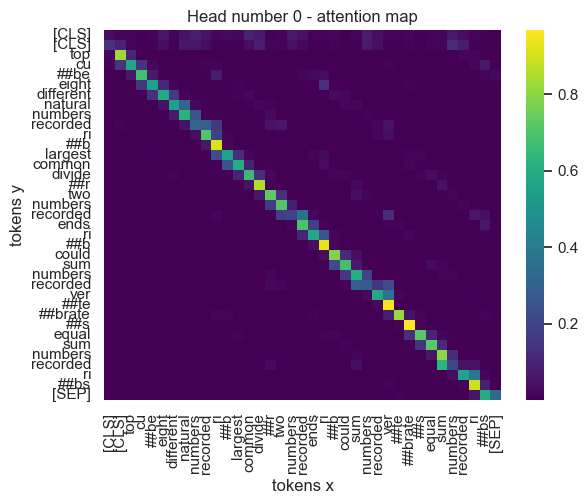

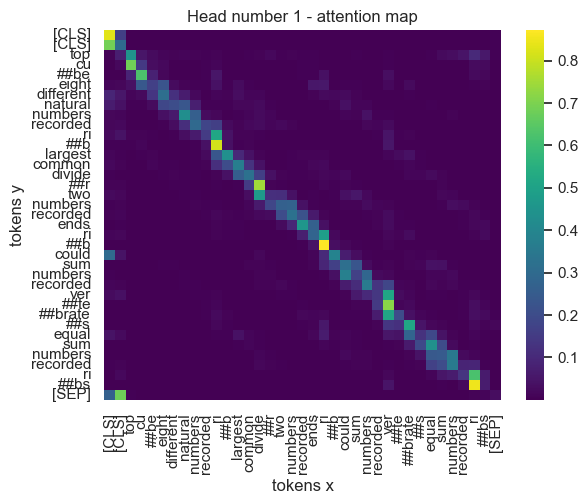

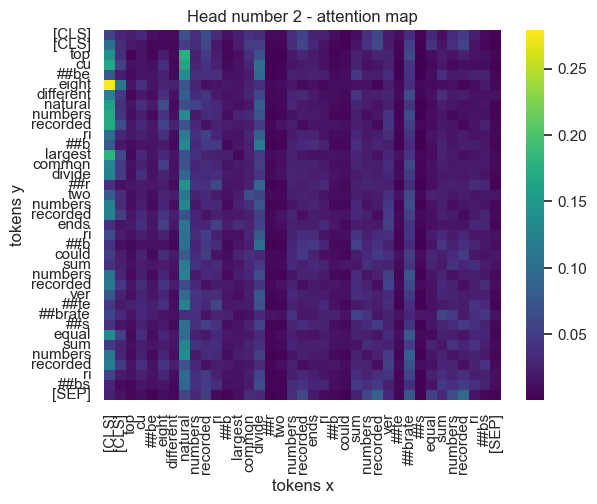

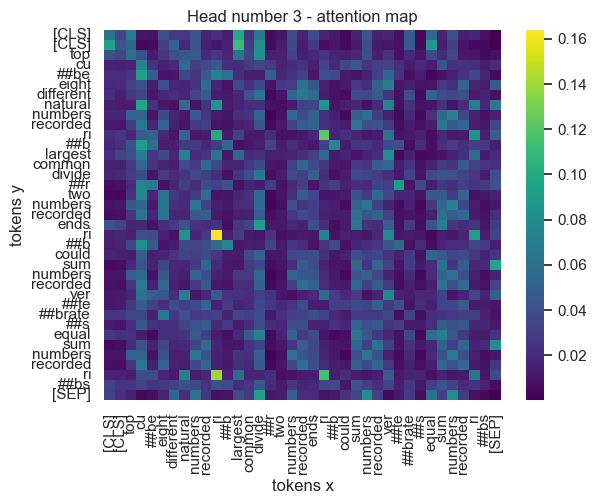

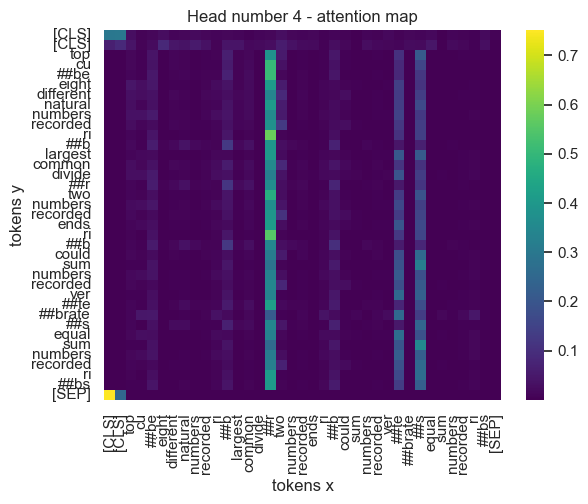

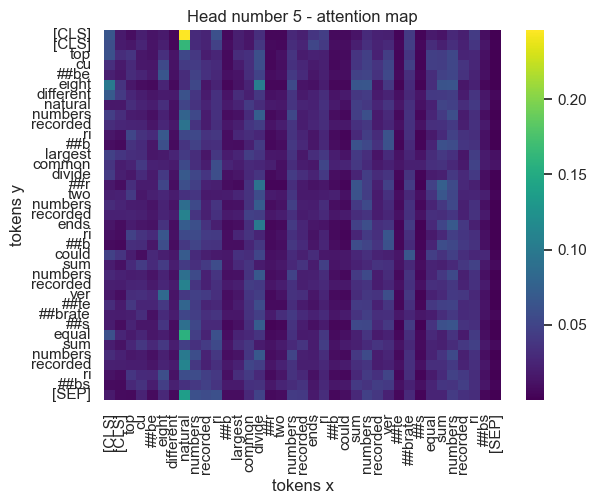

In [43]:
# Дообученная модель "Rubert - Tiny2" без заморозки слоев показала качество выше по accuracy на валидации, и хоть и склонна к переобучению, но оно не произошло в явном виде, так как было всего 7 эпох.
## Поэтому возьмем ее

draw_first_layer_attention_maps(text_loader=train_dataset, model=rubert_tiny_unfrz, tokenizer=tokenizer_rt)

Всего голов Attention = 12, мы отрисуем 50.0% из них


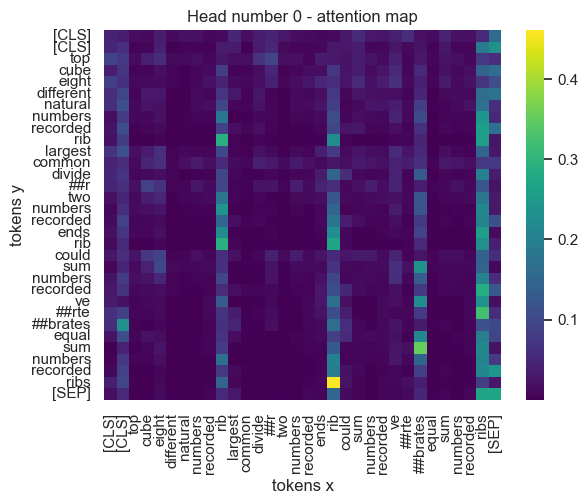

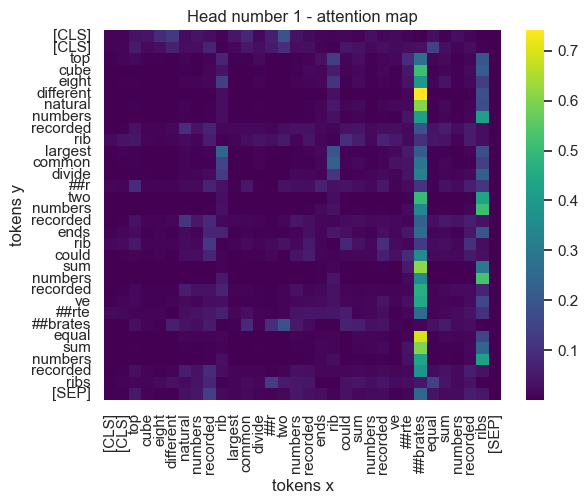

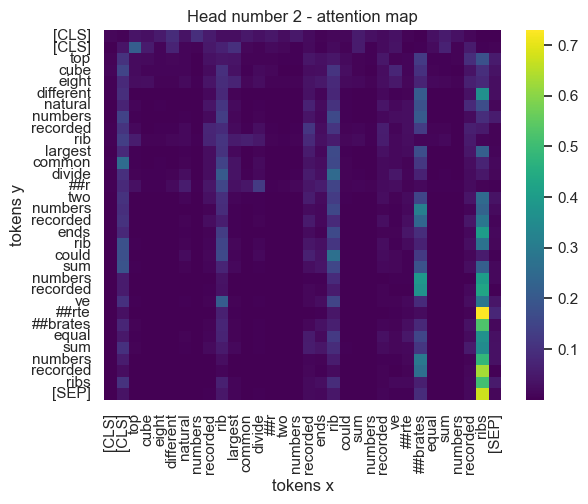

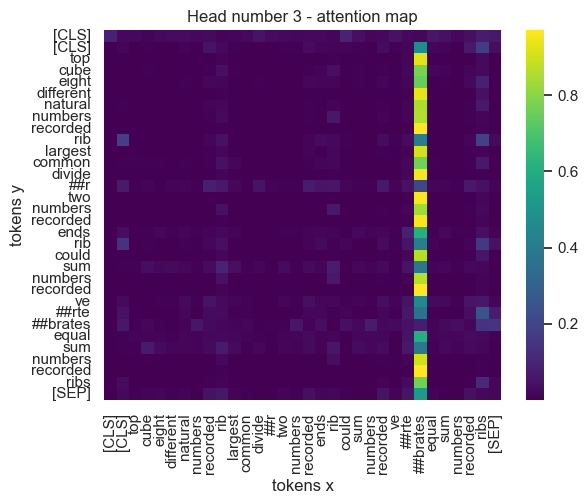

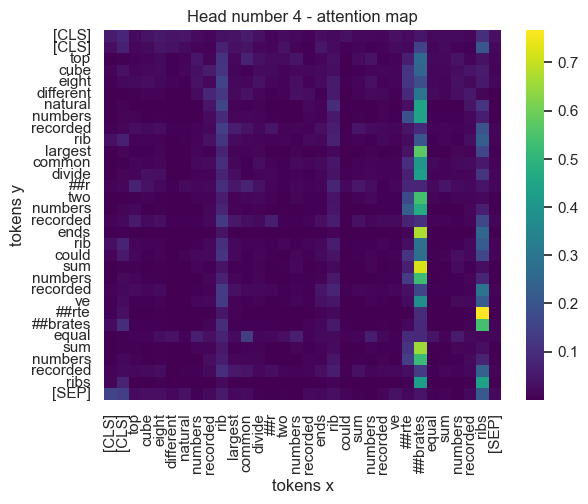

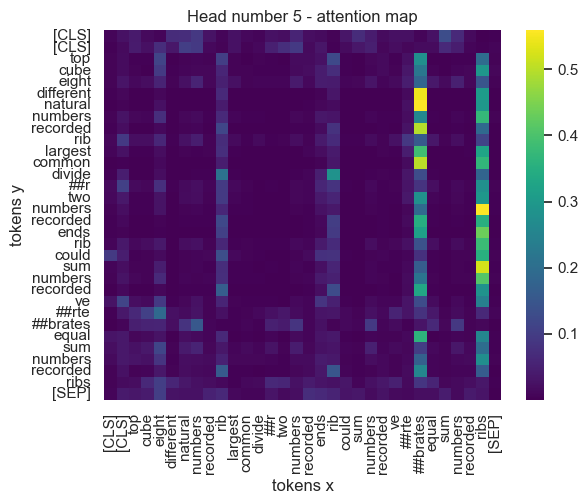

In [44]:
# Дообученная модель "MathBert" c заморозки слоев показала качество по loss и accuracy хуже, чем с заморозкой. Однако не склонна к переобучению, поэтому возьмем ее

draw_first_layer_attention_maps(text_loader=train_dataset, model=mathbert_frz, tokenizer=tokenizer_mb)

---
## Выводы по картам внимания 4х моделей

1) Для отрисовки карт внимания, перед этим в функцию draw_first_layer_attention_maps мы переносим препроцесс текст из датасета и токенизируем его, возвращая тензоры. Основное изменение в выходе токенайзера - это транкейт и паддинг (смотрим на предобработанное предложение).
2) Также для ненагромождения картами - при инициализации датасета, выбирается предложение из исходного датасета next(iter(.text))!
3) В функции отрисовки можем задать % отрисовки голов внимания от общего числа голов. В примере приведено дефолное значение 50%.
4) По картам внимания, видно что:
   
    * Модели rubert-tiny2 более сконцентрированы по диагонали на первых двух головах (токены улавливают связь на самих себя), однако большой разницы с дообученной и недообученной нет. Из разницы можно увидеть что токен по оси абцисс x "r" в размороженной модели больше обращает внимание на почти все токены, расположенные на оси ординат (вертикальная линия более яркая), в то время как в недообученной модели эта вертикальная линия более яркая для токена "s";
    * Моделей Mathbert карты более интересные, так как диагональных ярких линий нет, но есть много вертикальных. Означает, что токен в течение предложения является часто обращающим на себя внимание. В недообученной и в дообученной моделях также разницы малозначительны, лишь небольшая яркость добавляется по вниманию нескольких токенов в предложении.
  
    * * За меленькие карты внимания заранее извиняюсь, сделал так, чтобы в 5мб влез ноутбук...
---